In [1]:
# !pip install albumentations

In [2]:

from PIL import Image
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
from model.network import Unsupervised_Object_Detection
import matplotlib.pyplot as plt
from model.utils import disp_activation, get_activation
import torchvision.transforms.functional as F


im = Image.open('images/bottle0.jpg')
target_list = {
    'boxes': torch.tensor([[103, 212, 495, 746]], dtype=torch.float32), # xmin, ymin, xmax, ymax
    'labels': torch.tensor([1], dtype=torch.int64),  # Class label should be int64
    # 'image_id': torch.tensor([1], dtype=torch.int64)  # Unique ID should be int64
}

im_test = Image.open('images/bottle2.jpg')
model = Unsupervised_Object_Detection()
# zi, zj, za = model(im)


# Train

In [3]:
import torch
from model.utils import random_rotate_image, random_augment
from model.loss_func import nt_xent_loss

# Pre-training function
def pre_train_one_image(model, image, optimizer, scheduler, loss_fn, epochs=10, patience=3, save_path='best_model.pth'):
    best_loss = float('inf')
    best_epoch = 0
    patience_counter = 0

    model.train()
    
    for epoch in range(epochs):
        new_im = random_augment(image)
        optimizer.zero_grad()

        # Forward pass
        zi, zj, za = model(new_im)
        loss = loss_fn(zi, zj, za)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Step the scheduler with the current loss
        scheduler.step(loss.item())

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

        # Check if the current loss is the best we've seen so far
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch
            patience_counter = 0

            # Save the best model
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with loss {best_loss} at epoch {best_epoch + 1}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            break

    # Optionally load the best model after training
    model.load_state_dict(torch.load(save_path))
    print(f"Training completed. Best model from epoch {best_epoch + 1} loaded.")

# Define the necessary components
loss_fn = nt_xent_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Run the pre-training loop
pre_train_one_image(model, im, optimizer, scheduler, loss_fn, epochs=15, patience=3, save_path='best_model.pth')


/Users/erezshani/Projects/Unsupervised_costractive/model/pipelines.py:123: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/torch/csrc/utils/tensor_new.cpp:233.)
  return torch.tensor(anchor_negatives, device=fpn_output.device)


Epoch 1/15, Loss: 2.6609396934509277
Best model saved with loss 2.6609396934509277 at epoch 1
Epoch 2/15, Loss: 1.1737713813781738
Best model saved with loss 1.1737713813781738 at epoch 2
Epoch 3/15, Loss: 3.641052722930908
Epoch 4/15, Loss: 0.30194780230522156
Best model saved with loss 0.30194780230522156 at epoch 4
Epoch 5/15, Loss: 0.19634947180747986
Best model saved with loss 0.19634947180747986 at epoch 5
Epoch 6/15, Loss: 0.16845685243606567
Best model saved with loss 0.16845685243606567 at epoch 6
Epoch 7/15, Loss: 0.14568445086479187
Best model saved with loss 0.14568445086479187 at epoch 7
Epoch 8/15, Loss: 0.06533960998058319
Best model saved with loss 0.06533960998058319 at epoch 8
Epoch 9/15, Loss: 0.1090136170387268
Epoch 10/15, Loss: 0.275799036026001
Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/15, Loss: 0.08902383595705032
Early stopping triggered after 3 epochs with no improvement.
Training completed. Best model from epoch 8 loaded.


Fine Tune

<hr>

# Load

In [4]:
# torch.save(model.state_dict(), 'best_model.pth')

# Load
model = Unsupervised_Object_Detection()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
print()

Plot

<hr>

In [5]:
from fine_tune_utiles import random_augment_ft

def fine_tune_retinanet(model, images, targets):

    model.train()
    # Freeze the backbone
    for param in model.backbone.parameters():
        param.requires_grad = False
    # Train head
    for param in model.head.parameters():
        param.requires_grad = True

    # optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.0001)
    optimizer = torch.optim.SGD(
        [param for param in model.parameters() if param.requires_grad],
        lr=0.0001,
        momentum=0.8,
        weight_decay=0.0001,
    )
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    num_epochs = 20

    
    new_im =  transforms.ToTensor()(images)
    new_target = targets
    for epoch in range(num_epochs):
        # new_im = [new_im]#.to('cuda')
        new_im = [new_im] 
        targets = [{k: v for k, v in new_target.items()}]

        # # Forward pass
        loss_dict = model(new_im, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # new_im = random_augment(images)
        new_im, new_target = random_augment_ft(images, new_target)
        new_im = transforms.ToTensor()(new_im)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {losses.item():.4f}")
    scheduler.step()
    

fine_tune_retinanet(model.P2.retinanet,im,target_list)

Epoch [1/20], Loss: 1.5819
Epoch [2/20], Loss: 1.6825
Epoch [3/20], Loss: 1.6680
Epoch [4/20], Loss: 1.4039
Epoch [5/20], Loss: 1.4493
Epoch [6/20], Loss: 1.4218
Epoch [7/20], Loss: 1.6831
Epoch [8/20], Loss: 1.4179
Epoch [9/20], Loss: 1.5261
Epoch [10/20], Loss: 1.5350
Epoch [11/20], Loss: 1.4079
Epoch [12/20], Loss: 1.5338
Epoch [13/20], Loss: 1.4626
Epoch [14/20], Loss: 1.5544
Epoch [15/20], Loss: 1.3324
Epoch [16/20], Loss: 1.3691
Epoch [17/20], Loss: 1.4398
Epoch [18/20], Loss: 1.3915
Epoch [19/20], Loss: 1.5347
Epoch [20/20], Loss: 1.3678



<hr>

tensor([0.1205, 0.1111, 0.0942, 0.0936, 0.0918, 0.0916, 0.0915, 0.0895, 0.0881,
        0.0836, 0.0817, 0.0800, 0.0799, 0.0791, 0.0757, 0.0751, 0.0737, 0.0729,
        0.0724, 0.0722, 0.0720, 0.0705, 0.0686, 0.0673, 0.0666, 0.0655, 0.0651,
        0.0649, 0.0642, 0.0633, 0.0633, 0.0630, 0.0629, 0.0623, 0.0622, 0.0610,
        0.0608, 0.0607, 0.0603, 0.0595, 0.0594, 0.0591, 0.0582, 0.0579, 0.0575,
        0.0570, 0.0567, 0.0565, 0.0563, 0.0562, 0.0560, 0.0559, 0.0556, 0.0555,
        0.0555, 0.0552, 0.0551, 0.0548, 0.0546, 0.0545, 0.0545, 0.0544, 0.0544,
        0.0544, 0.0541, 0.0540, 0.0537, 0.0532, 0.0527, 0.0525, 0.0522, 0.0520,
        0.0520, 0.0520, 0.0519, 0.0517, 0.0516, 0.0515, 0.0514, 0.0514, 0.0513,
        0.0512, 0.0511, 0.0510, 0.0510, 0.0509, 0.0508, 0.0505, 0.0503, 0.0501,
        0.0500])


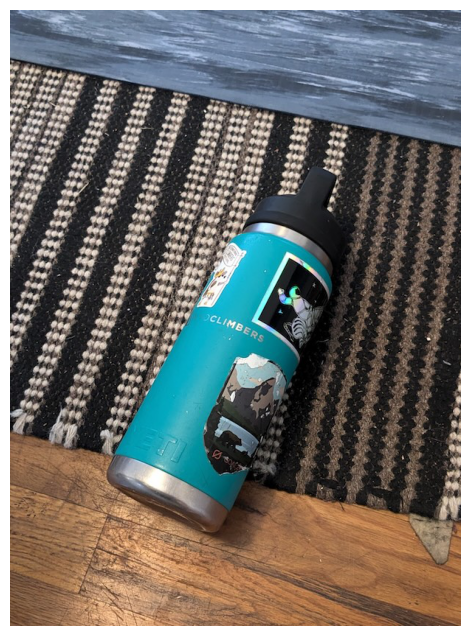

In [15]:
rtina = model.P2.retinanet
rtina.eval()
import torchvision.transforms.functional as F

from PIL import Image, ImageDraw
def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    return img

def predict_and_plot(image_path, threshold=0.5):
    # Load image and convert to tensor
    img = load_image(image_path)
    img_tensor = F.to_tensor(img).unsqueeze(0)  # Add batch dimension

    # Perform prediction
    with torch.no_grad():
        predictions = rtina(img_tensor)[0]

    # Filter out boxes below the confidence threshold
    boxes = predictions['boxes']
    scores = predictions['scores']
    labels = predictions['labels']
    print( scores)

    selected_boxes = boxes[scores > threshold].numpy()

    # Draw boxes on the image
    draw = ImageDraw.Draw(img)
    for box in selected_boxes:
        draw.rectangle(box.tolist(), outline="red", width=3)

    # Display the image with bounding boxes
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

predict_and_plot('images/bottle0.jpg')

0
1
2
p6
p7


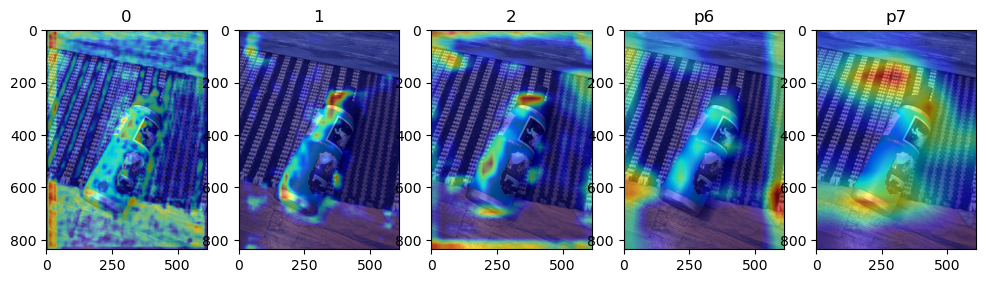

In [7]:
from model.utils import disp_activation, get_activation

tensor_im = transforms.ToTensor()(im)
output = model.P2.retinanet.backbone(tensor_im)
N_images = len(output)
fig, ax = plt.subplots(1,N_images, figsize = (12,12))
for i, (name,data) in enumerate(output.items()):
    print(name)
    disp_activation(data.mean(1), im,ax[i], name)



In [8]:
from testing_functions import livecam_test
from capture_box_from_image import draw_rectangle
# draw_rectangle(cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR))

In [9]:
# livecam_test(model)

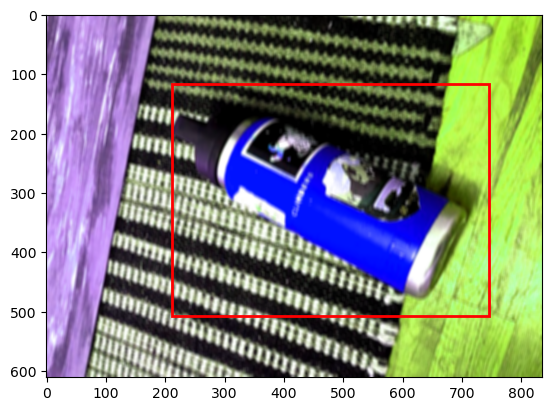

In [17]:
from fine_tune_utiles import flip_boxes_horizontally,flip_boxes_vertically,rotate_image_and_boxes, plot_image_with_boxes
import random
img = im.copy()
target_list = {
    'boxes': torch.tensor([[103, 212, 495, 746]], dtype=torch.float32), # xmin, ymin, xmax, ymax
    'labels': torch.tensor([1], dtype=torch.int64),  # Class label should be int64
    # 'image_id': torch.tensor([1], dtype=torch.int64)  # Unique ID should be int64
}

image_width, image_height = img.size
boxes = target_list['boxes'].clone()

img = F.hflip(img)
boxes = flip_boxes_horizontally(boxes, image_width)

img = F.vflip(img)
boxes = flip_boxes_vertically(boxes, image_height)

angle = random.choice([90, 180, 270])  # Don't rotate by 0
img, boxes = rotate_image_and_boxes(img, boxes, angle)
        
img = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2)(img)
img = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0))(img)
        
img = transforms.ToTensor()(img)
img = F.to_pil_image(img)
new_transformed_target = target_list.copy()
new_transformed_target['boxes'] = boxes
plot_image_with_boxes(img, new_transformed_target['boxes'].numpy())

In [11]:
boxes

tensor([[ 90., 103., 624., 495.]])

In [12]:
target_list['boxes']

tensor([[103., 212., 495., 746.]])

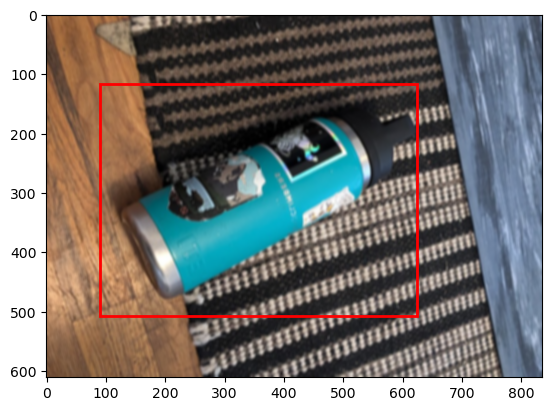

In [13]:
images, new_target = random_augment_ft(im, target_list)
images = transforms.ToTensor()(images)
plot_image_with_boxes(F.to_pil_image(images), new_target['boxes'].numpy())

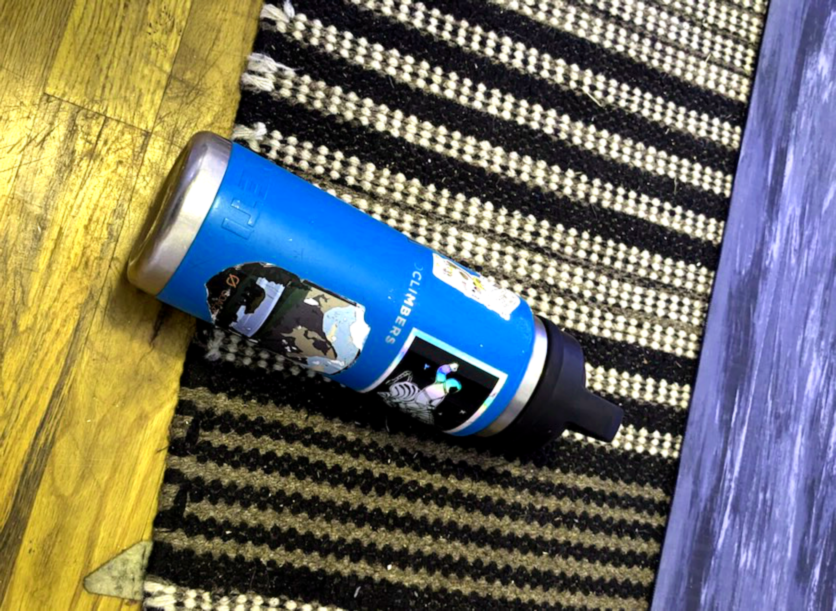

In [14]:
img